# 1. Construa um classificador e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

* **métricas:** precision, recall e F1-score;

* **dados:** classification_data.zip;

## 0.0. IMPORTS

In [280]:
import random
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

from IPython.core.display import HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

### 0.1. Helper Functions

In [281]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading Data

In [282]:
df_classification_raw_train = pd.read_csv('datasets/classification_train.csv')
df_classification_raw_test = pd.read_csv('datasets/classification_test.csv')

In [283]:
df_classification_raw_test.head()

,x1,x2,target
0,1.11,-0.43,1
1,-1.24,0.52,0
2,-0.09,-0.17,1
3,0.30,0.08,0
4,-0.27,0.48,1


In [284]:
df_classification_raw_train.head()

,x1,x2,target
0,1.93,-0.11,1
1,1.77,-0.98,1
2,0.94,-0.09,1
3,1.34,0.17,1
4,-0.20,-0.16,1


## 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [285]:
df1 = df_classification_raw_train.copy()
x_test = df_classification_raw_test.copy()

### 1.1. Data Info

In [286]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      670 non-null    float64
 1   x2      670 non-null    float64
 2   target  670 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 15.8 KB


In [287]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      330 non-null    float64
 1   x2      330 non-null    float64
 2   target  330 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 7.9 KB


### 1.2. Estatística Descritiva

In [288]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])

### 1.3. Atributos Numéricos

In [289]:
describe(df1, ['skew', 'kurt'])

,x1,x2,target
count,670.00,670.00,670.00
mean,0.48,0.26,0.51
std,0.91,0.62,0.50
min,-1.94,-1.31,0.00
25%,-0.17,-0.16,0.00
50%,0.49,0.28,1.00
75%,1.16,0.72,1.00
max,2.59,1.90,1.00
skew,-0.05,-0.07,-0.02
kurt,-0.68,-0.45,-2.01


<AxesSubplot: >

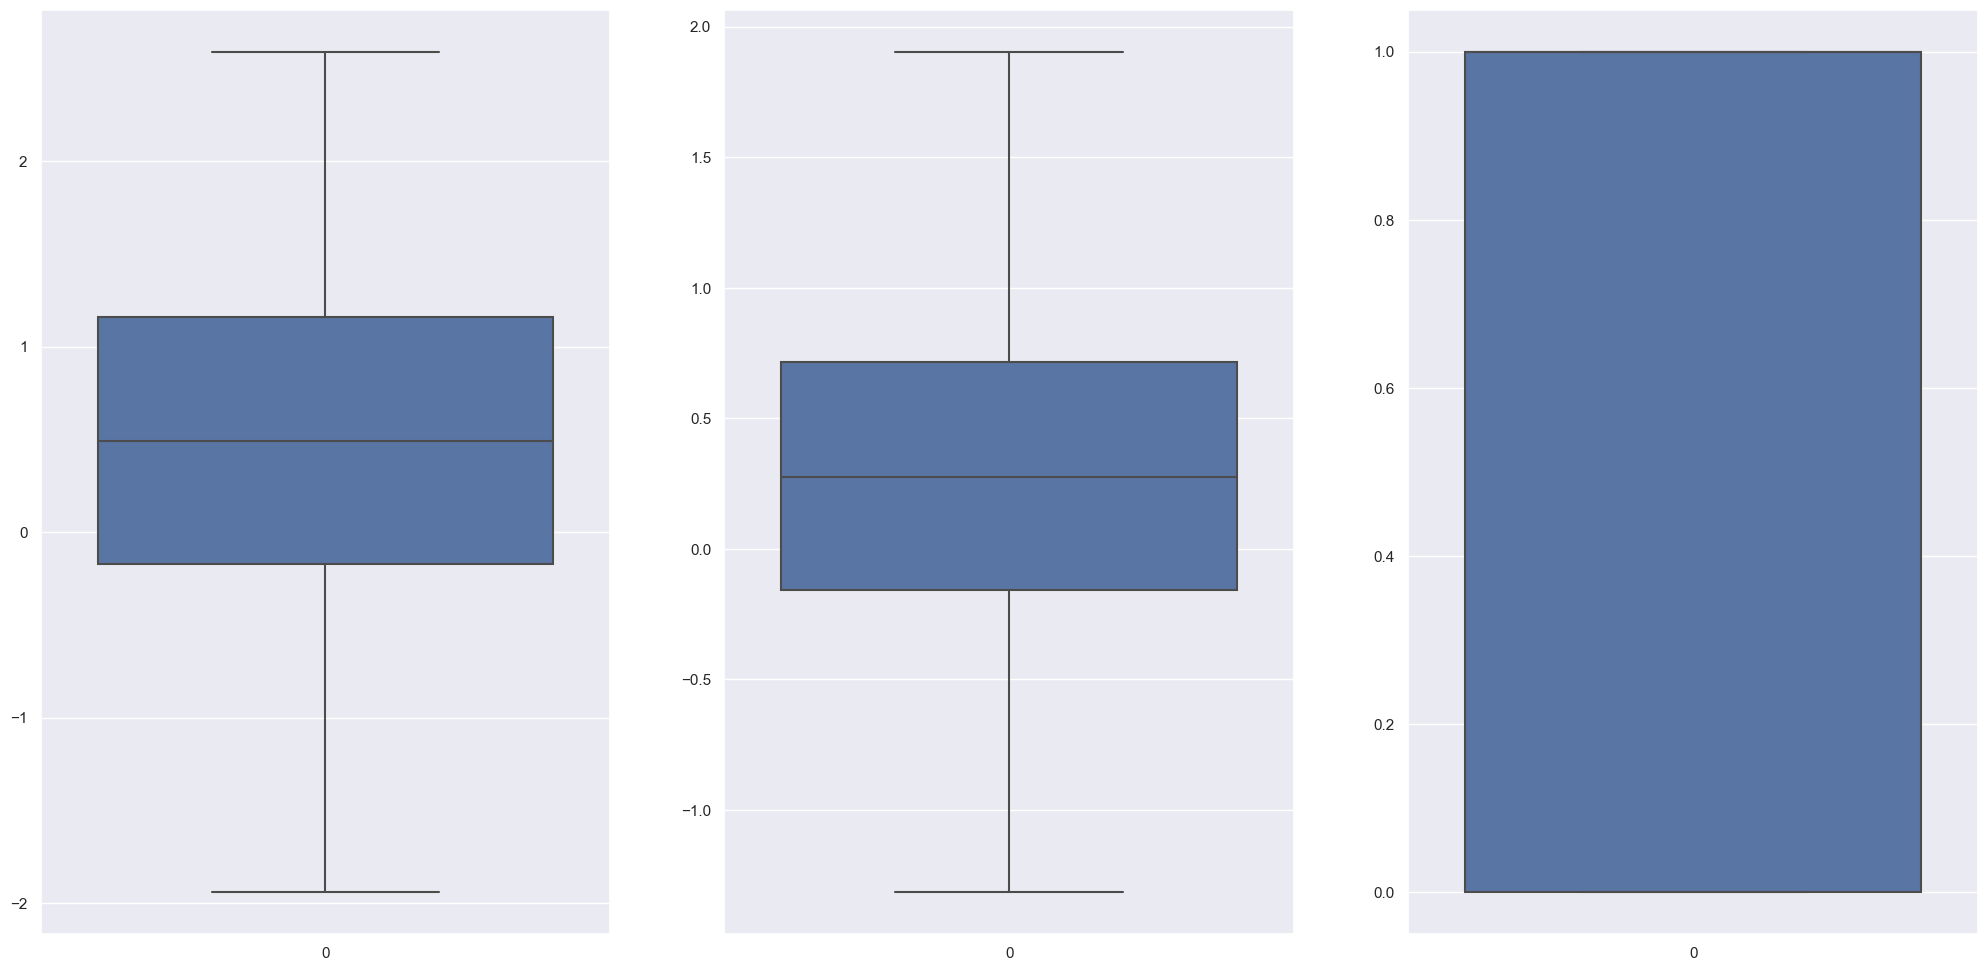

In [290]:
plt.subplot (1, 3, 1)
sns.boxplot (df1['x1'])

plt.subplot (1, 3, 2)
sns.boxplot (df1['x2'])

plt.subplot (1, 3, 3)
sns.boxplot (df1['target'])

**1.** Dataset livre de NA e outliers

## 2.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [291]:
df2 = df1.copy()

### 2.1. Análise Univariada

#### 2.1.1. Variável Resposta

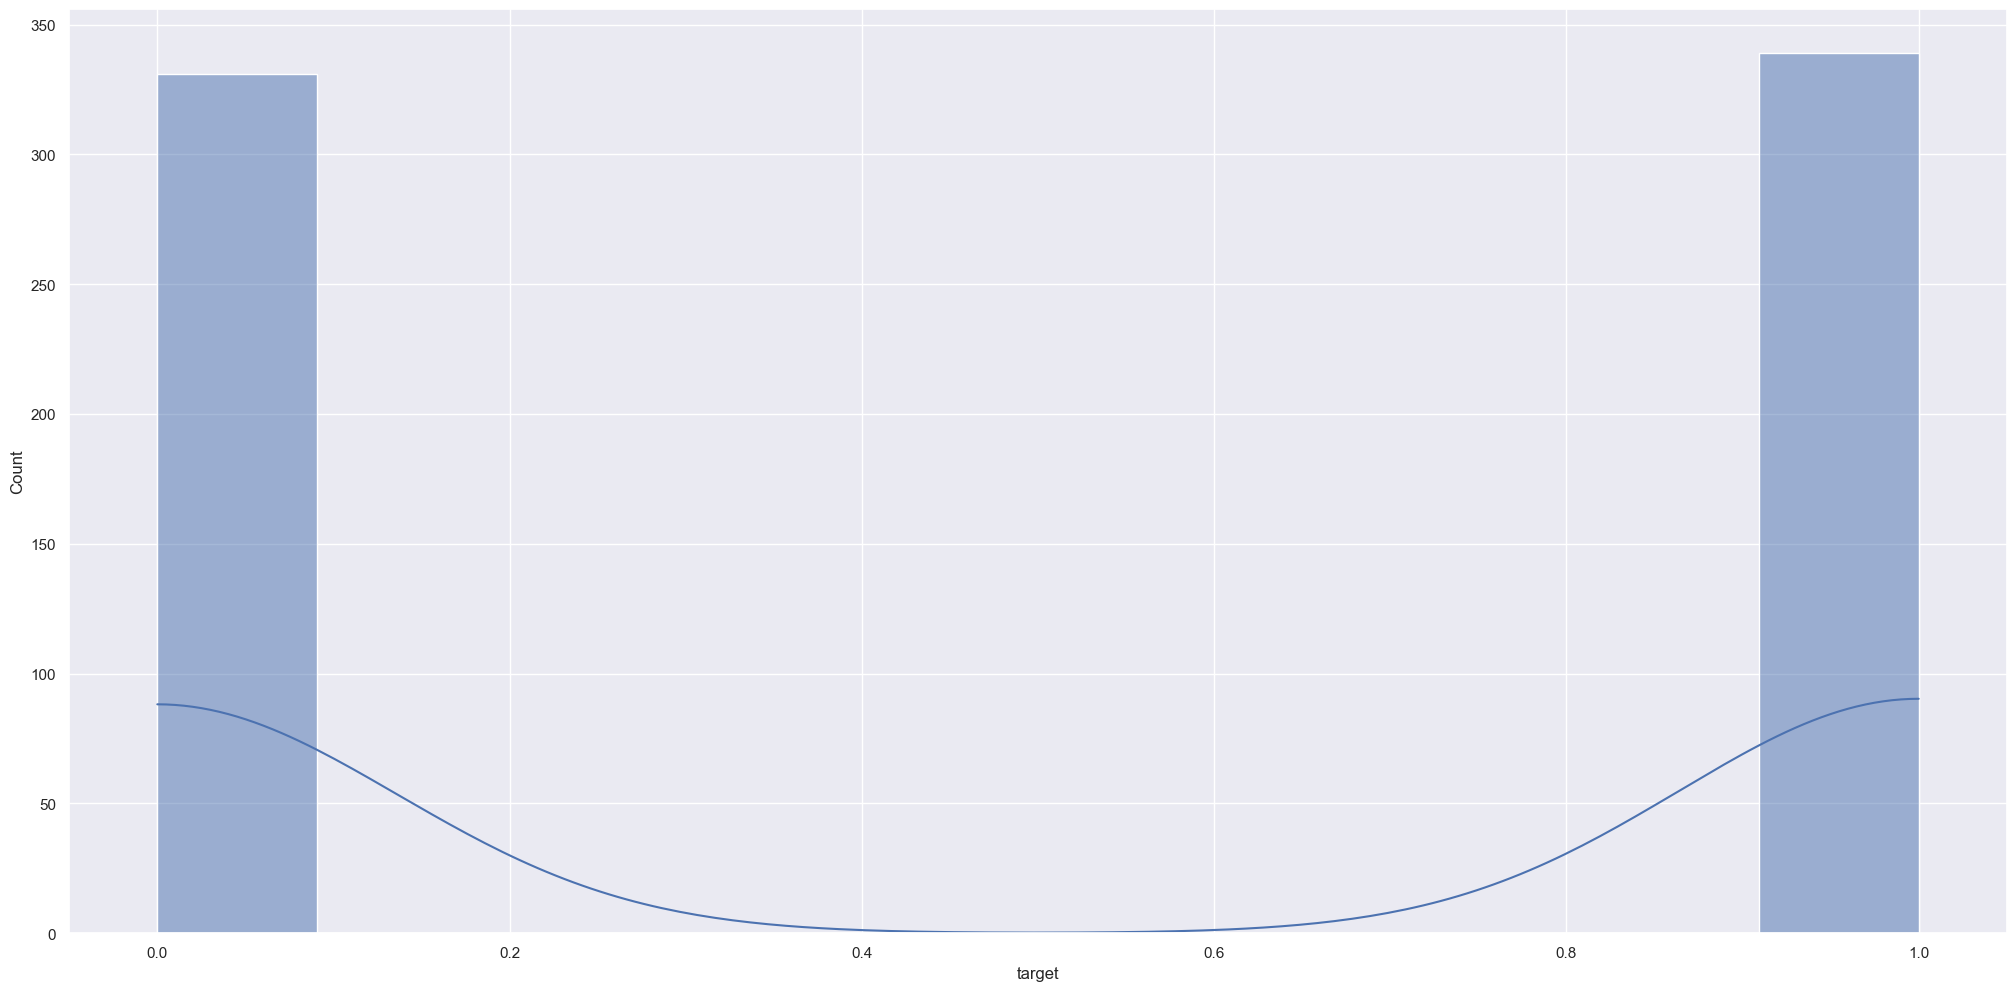

In [292]:
sns.histplot(df2['target'], kde = True);

#### 2.1.2. Variáveis Numéricas

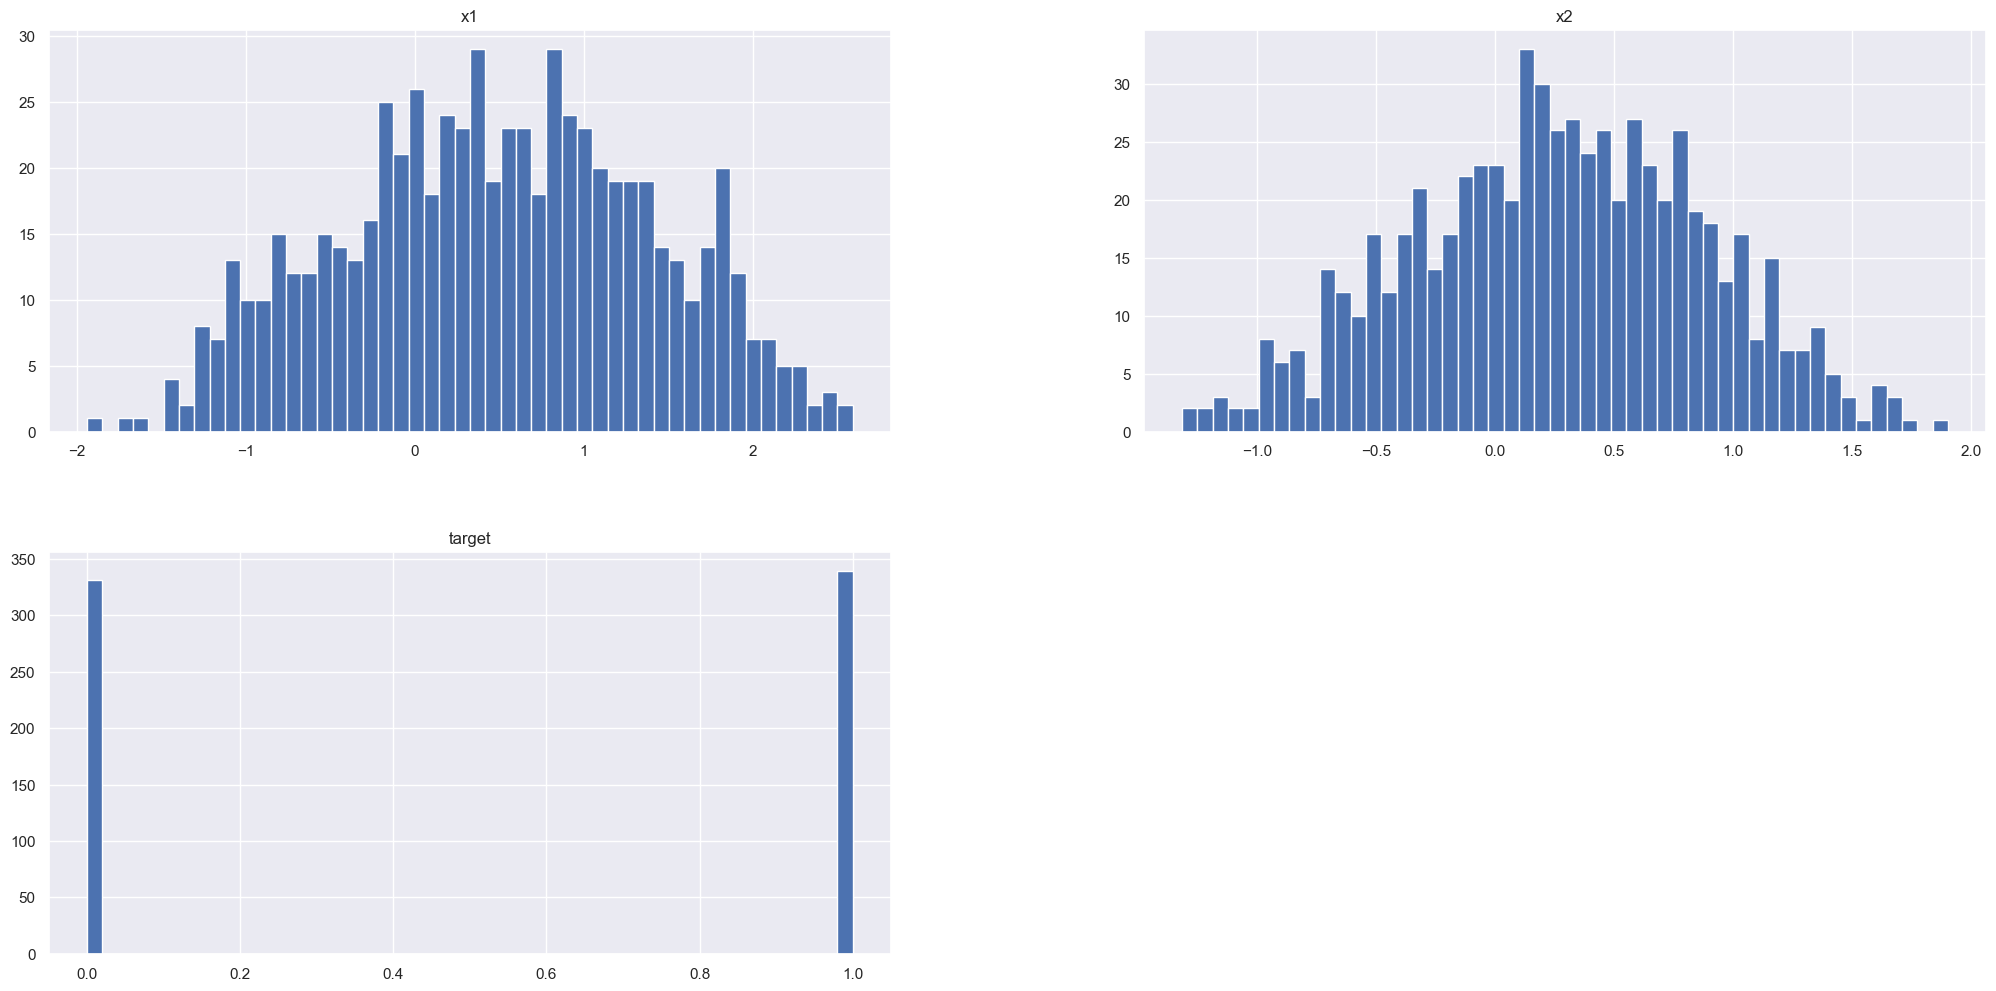

In [293]:
num_attributes.hist (bins = 50);

### 2.2. Análise Multivariada

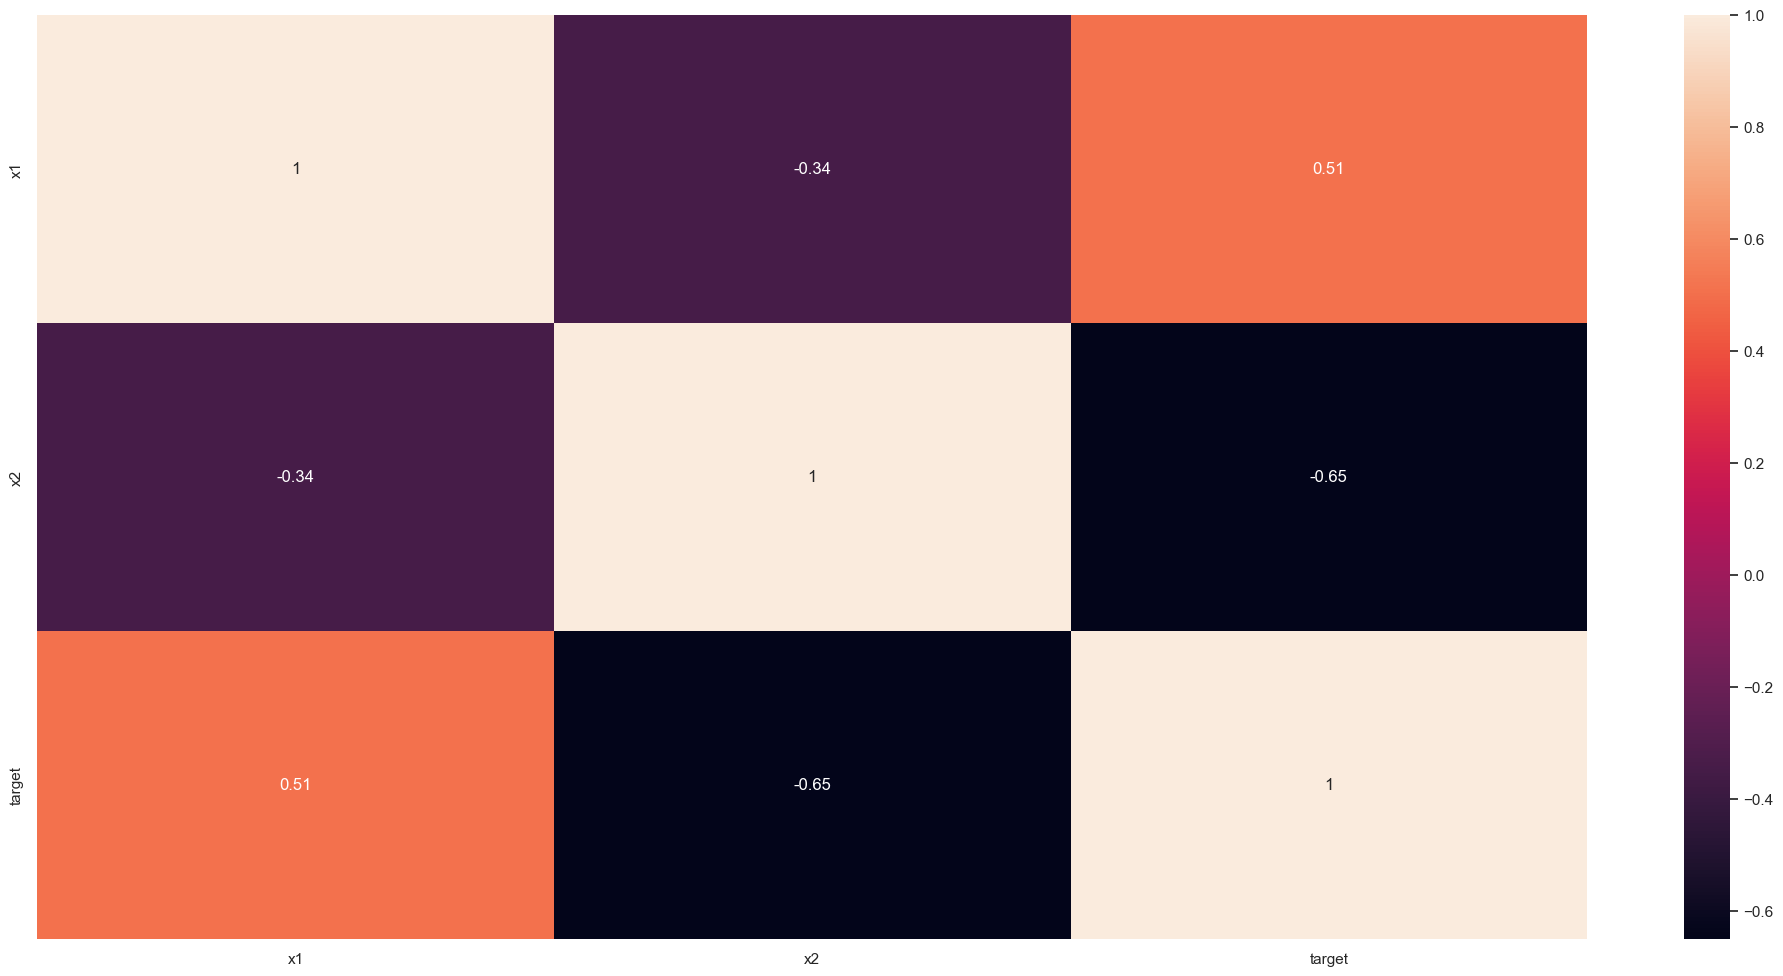

In [294]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

## 3.0. PASSO 03 - PREPARAÇÃO DOS DADOS

In [295]:
df3 = df2.copy()

### 3.1. Rescaling

In [296]:
mms = MinMaxScaler()

# X1
df3['x1'] = mms.fit_transform (df3[['x1']].values)

# X2
df3['x2'] = mms.fit_transform (df3[['x2']].values)

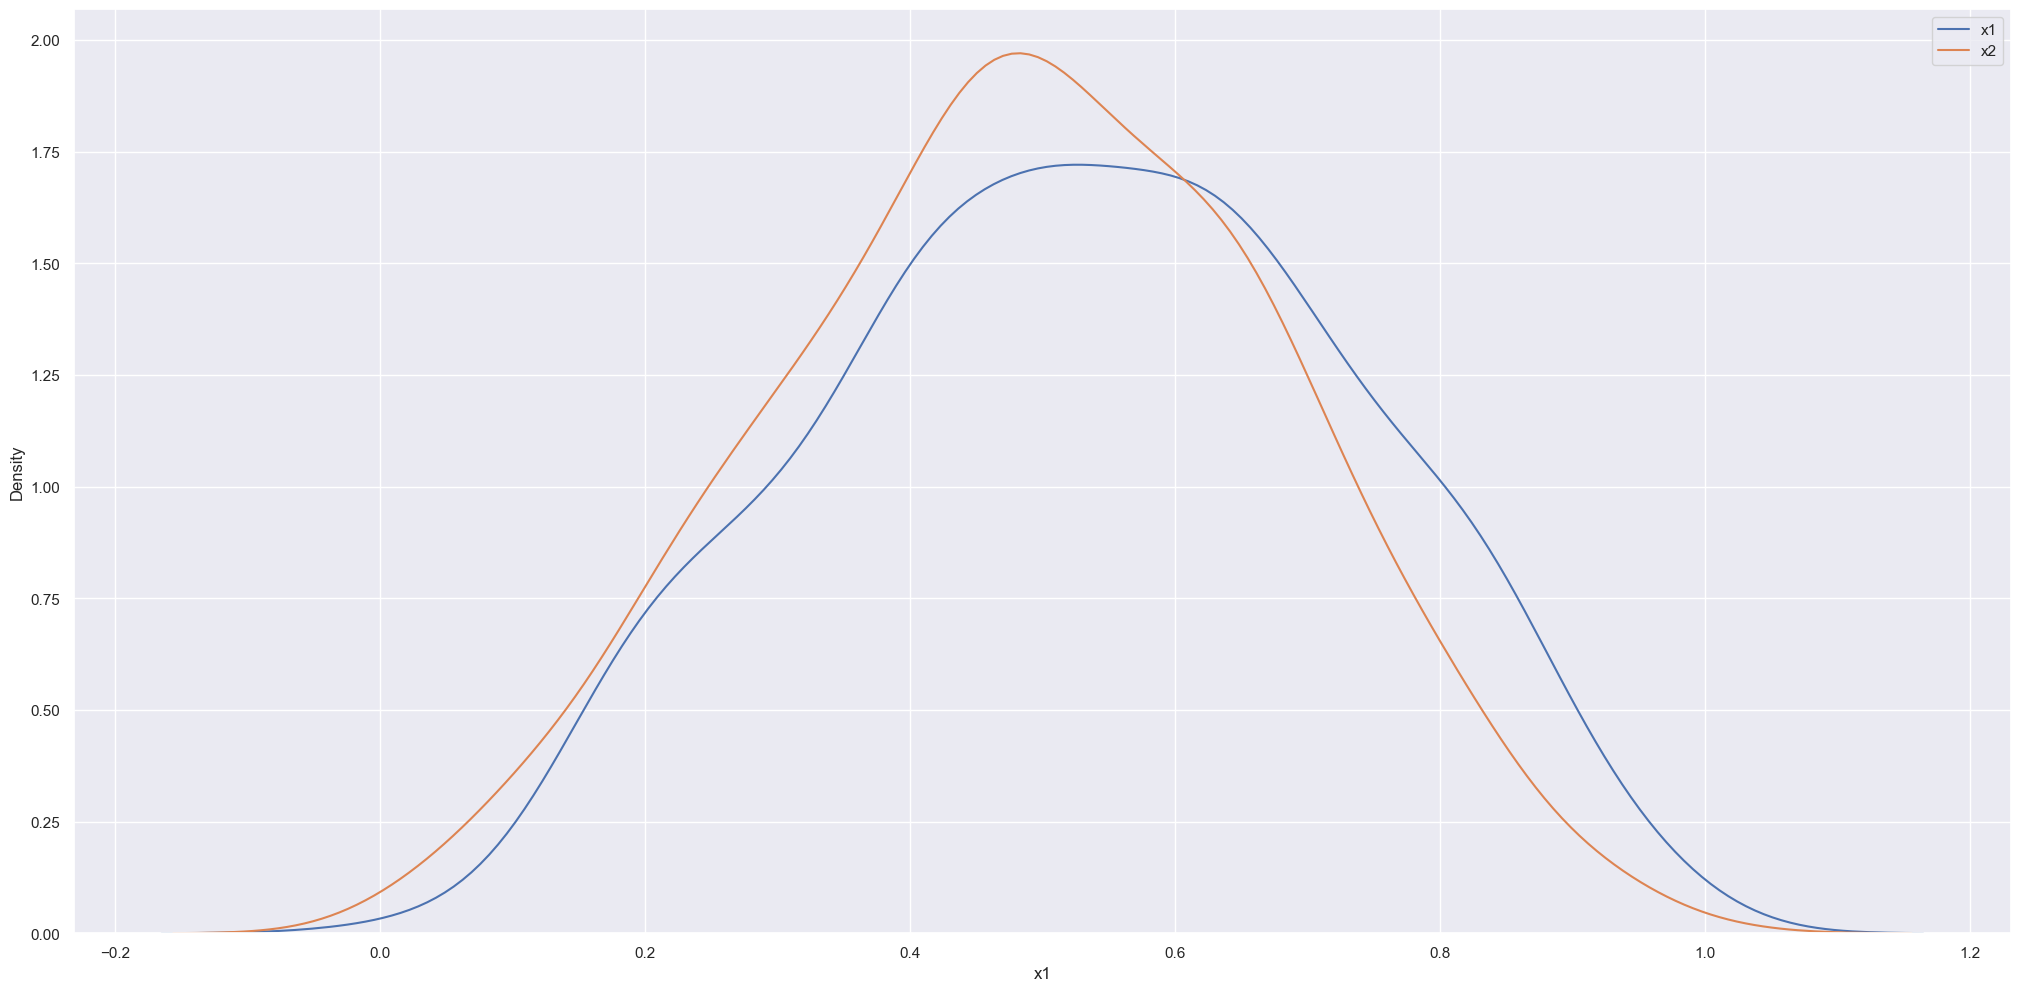

In [297]:
sns.kdeplot(df3['x1'], label = 'x1');
sns.kdeplot(df3['x2'], label = 'x2');
plt.legend(loc='upper right'); 

In [298]:
df3.head()

,x1,x2,target
0,0.86,0.37,1
1,0.82,0.10,1
2,0.64,0.38,1
3,0.72,0.46,1
4,0.38,0.36,1


## 4.0. PASSO 04 - MODELO MACHINE LEARNING

In [299]:
# train
X_train = df3[['x1', 'x2']]
y_train = df3['target']

# test
X_test = x_test.copy()
y_test = X_test.pop('target')

### 4.1. Rescaling Test Data

In [300]:
# X1
X_test['x1'] = mms.fit_transform (X_test[['x1']].values)

# X2
X_test['x2'] = mms.fit_transform (X_test[['x2']].values)

### 4.2. Modelos

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron

In [301]:
model = []
accuracy = []

#### 4.2.1 Logistic Regression

In [302]:
from sklearn.linear_model import LogisticRegression

LogisticModel = LogisticRegression().fit(X_train, y_train)

In [303]:
yhat_lr = LogisticModel.predict(X_test)

In [304]:
LogisticAccuracy = LogisticModel.score(X_test, y_test) * 100

model.append('Logistic Regression')

accuracy.append(LogisticAccuracy)

print(LogisticAccuracy)

84.24242424242424


#### 4.2.2 Support Vector Machine

In [305]:
from sklearn.svm import SVC

SVCModel = SVC().fit(X_train, y_train)

In [306]:
yhat_svm = SVCModel.predict(X_test)

In [307]:
SVCAccuracy = SVCModel.score(X_test, y_test) * 100

model.append('C-Support Vector Machine')

accuracy.append(SVCAccuracy)

print(SVCAccuracy)

85.15151515151516


#### 4.2.3 KNN

In [308]:
from sklearn.neighbors import KNeighborsClassifier

KNNModel = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

In [309]:
yhat_knn = KNNModel.predict(X_test)

In [310]:
KNNAccuracy = KNNModel.score(X_test, y_test) * 100

model.append('k-Nearest Neighbors')

accuracy.append(KNNAccuracy)

print(KNNAccuracy)

87.27272727272727


#### 4.2.4. Gaussian Naive Bayes

In [311]:
from sklearn.naive_bayes import GaussianNB

GaussianModel = GaussianNB().fit(X_train, y_train)

In [312]:
yhat_gnb = GaussianModel.predict(X_test)

In [313]:
GaussianAccuracy = GaussianModel.score(X_test, y_test) * 100

model.append('Gaussian Naive Bayes')

accuracy.append(GaussianAccuracy)

print(GaussianAccuracy)

84.24242424242424


#### 4.2.5. Perceptron

In [314]:
from sklearn.linear_model import Perceptron

PerceptronModel = Perceptron().fit(X_train, y_train)

In [315]:
yhat_ptron = PerceptronModel.predict(X_test)

In [316]:
PerceptronAccuracy = PerceptronModel.score(X_test, y_test) * 100

model.append('Perceptron')

accuracy.append(PerceptronAccuracy)

print(PerceptronAccuracy)

82.72727272727273


#### 4.2.6. Linear SVC

In [317]:
from sklearn.svm import LinearSVC

LinearSVCModel = LinearSVC().fit(X_train, y_train)

In [318]:
yhat_lsvc = LinearSVCModel.predict(X_test)

In [319]:
LinearSVCAccuracy = LinearSVCModel.score(X_test, y_test) * 100

model.append('LinearSVC')

accuracy.append(LinearSVCAccuracy)

print(LinearSVCAccuracy)

83.93939393939394


#### 4.2.7. Stochastic Gradient Descent

In [320]:
from sklearn.linear_model import SGDClassifier

SGDCModel = SGDClassifier().fit(X_train, y_train)

In [321]:
yhat_sgd = SGDCModel.predict(X_test)

In [322]:
SGDCAccuracy = SGDCModel.score(X_test, y_test) * 100

model.append('Stochastic Gradient Descent')

accuracy.append(SGDCAccuracy)

print(SGDCAccuracy)

80.9090909090909


#### 4.2.8. Decision Tree Classifier

In [323]:
from sklearn.tree import DecisionTreeClassifier

DecisionTreeModel = DecisionTreeClassifier().fit(X_train, y_train)

In [324]:
yhat_dtree = DecisionTreeModel.predict(X_test)

In [325]:
DecisionTreeAccuracy = DecisionTreeModel.score(X_test, y_test) * 100

model.append('Decision Tree Classifier')

accuracy.append(DecisionTreeAccuracy)

print(DecisionTreeAccuracy)

81.51515151515152


#### 4.2.9. Random Forest

In [326]:
from sklearn.ensemble import RandomForestClassifier

RandomForestModel = RandomForestClassifier().fit(X_train, y_train)

In [327]:
yhat_rf = RandomForestModel.predict(X_test)

In [328]:
RandomForestAccuracy = RandomForestModel.score(X_test, y_test) * 100

model.append('Random Forest')

accuracy.append(RandomForestAccuracy)

print(RandomForestAccuracy)

86.66666666666667


### 4.3. Tabela de Acurácia

In [329]:
ModelSummary = pd.DataFrame(index = model)

ModelSummary['Accuracy'] = accuracy

ModelSummary.sort_values(by = 'Accuracy', ascending = False)

,Accuracy
k-Nearest Neighbors,87.27
Random Forest,86.67
C-Support Vector Machine,85.15
Logistic Regression,84.24
Gaussian Naive Bayes,84.24
LinearSVC,83.94
Perceptron,82.73
Decision Tree Classifier,81.52
Stochastic Gradient Descent,80.91


**1.** Os algoritmos desempanharam muito bem.

**2.** O algoritmo escolhido para a produção será o *Random Forest*, já que o dataset possui poucos valores e sua desvantagem de otimização de tempo será reduzida.

## 5.0. PASSO 05 - HYPERPARAMETER FINE TUNING

### 5.1. Random Search

In [330]:
param = {
            'bootstrap': [True],
            'max_depth': [None, 80, 90, 100, 110],
            'max_features': [2, 3, 5],
            'min_samples_leaf': [1, 3, 4, 5],
            'min_samples_split': [3, 8, 10, 12],
            'n_estimators': [100, 500, 1000, 1500, 2500]}

MAX_EVAL = 20

In [331]:
#rf = RandomForestClassifier (random_state = 42)
#
#final_result = pd.DataFrame()
#rf_result = []
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    # model
#    rf = RandomForestClassifier(bootstrap = True,
#            n_estimators=hp['n_estimators'],
#            max_depth=hp['max_depth'],
#            max_features = hp['max_features'],
#            min_samples_leaf = hp['min_samples_leaf'],
#            min_samples_split = hp['min_samples_split']).fit(X_train, y_train)
#    
#    # prediction
#    yhat_rf_tuned = rf.predict(X_test)
#
#    # performance
#    rf_result.append( rf.score(X_test, y_test) * 100)
#    rf_result

In [332]:
#rf_result

In [333]:
best_param = {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

In [347]:
rf_tuned = RandomForestClassifier(bootstrap = True,
                                  max_depth =  90,
                                  max_features = 3,
                                  min_samples_leaf = 1,
                                  min_samples_split = 10,
                                  n_estimators = 1000).fit(X_train, y_train)

In [348]:
yhat_rf_tuned = rf_tuned.predict(X_test)

In [349]:
RandomForestAccuracyTuned = rf_tuned.score(X_test, y_test) * 100

model.append('Random Forest Tuned')

accuracy.append(RandomForestAccuracyTuned)

print(RandomForestAccuracyTuned)

87.27272727272727


**1.** A busca pelos melhores parâmetros para fine tuning foi via Random Search. Com isso, o algoritmo apresentou 87.28% de acurácia, uma melhora de 0.61 %

### 4.4. Métricas

#### 4.4.1 Matriz de Confusão

In [337]:
cm = confusion_matrix(y_test, yhat_rf)

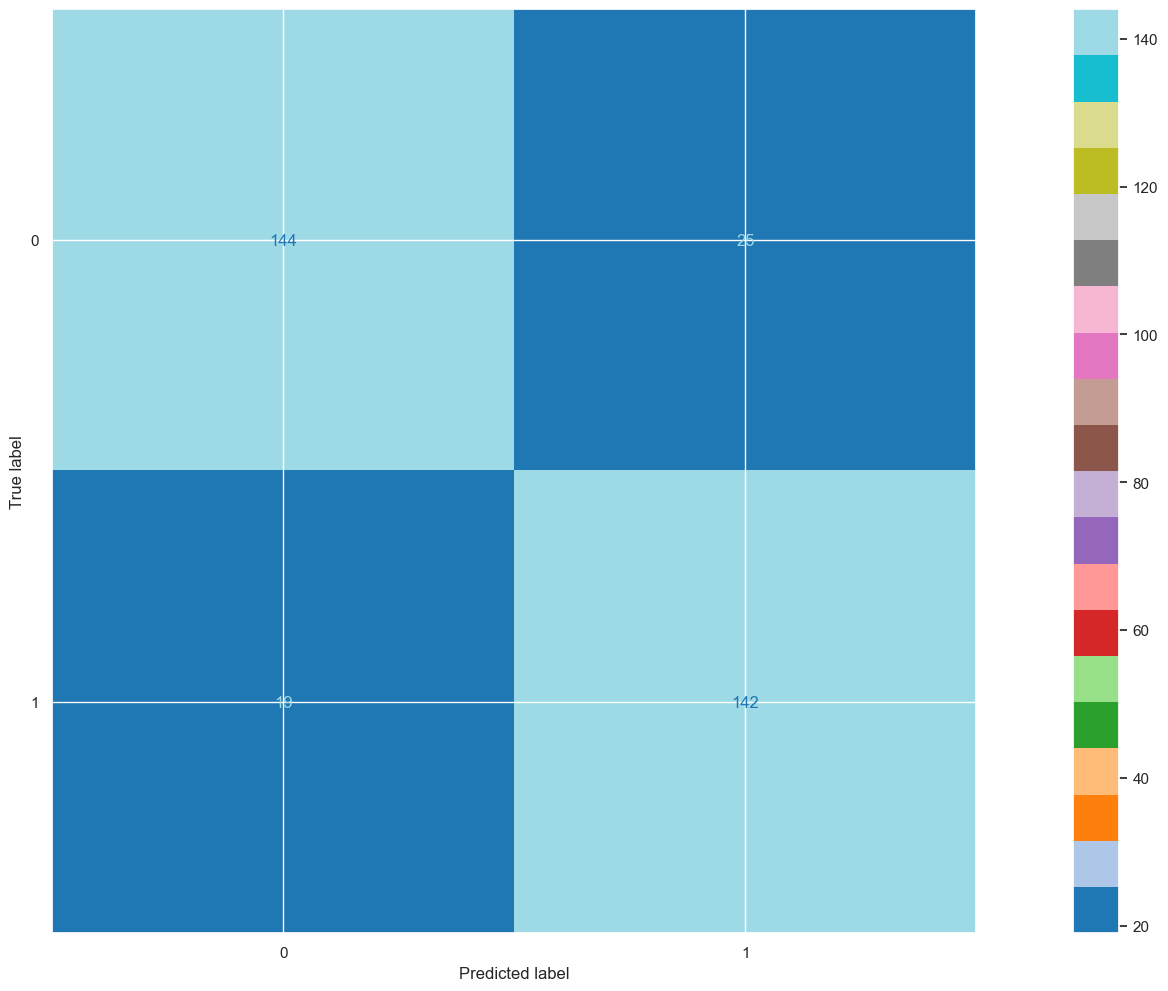

In [338]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='tab20')
plt.show()

In [339]:
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

#### 4.4.2 Precisão

In [340]:
prec = tp / (tp + fp)
prec

0.8502994011976048

#### 4.4.3. Recall

In [341]:
recall = tp / (tp + fn)
recall

0.8819875776397516

#### 4.4.4. F1 Score

In [342]:
f1_score = 2 * (prec *recall / (prec + recall))
f1_score

0.8658536585365854